# Code

In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import time
import os
import re
import matplotlib.pyplot as plt
import time
import numpy as np
import random
import sys
import torch
import pickle
from pathlib import Path
from torch.utils.data import DataLoader
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
sys.path.insert(0, '..')
from tqdm.notebook import tqdm
import seaborn as sns
import util.misc as utils
from util.params_dataloader import load_windows_and_multipliers
from dataset.data import (
    RNADataset,
    RNADatasetNT,
    RNADatasetNT500,
    EasyPosAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    HFDataset,
    HFDataLoader, 
    create_augment_list,
    plot_sample,
    seed_everything,
    clean_nt_dataframes_before_class_input,
)
from train_binary_cl import seed_worker, obtain_train_dataset, obtain_val_dataset, obtain_val_dataset_paris, obtain_train_dataset_paris, undersample_df, obtain_policies_object, obtain_dataset_object, get_per_sample_from_proportion
from config import *

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
def print_df_len(df_len, xlim = 1_000, bins = 400):
    df_len[df_len.label == 'p'].length.hist(bins = bins)
    plt.xlim((0,xlim))
    plt.show()
    df_len[df_len.label == 'sn'].length.hist(bins = bins)
    plt.xlim((0,xlim))
    plt.show()
    df_len[df_len.label == 'enhn'].length.hist(bins = bins)
    plt.xlim((0,xlim))
    plt.show()

In [60]:
DIMENSION = 200
FINETUNING = True
TRAIN_HQ = False
SPECIE = 'all'

scaling_factor = 5
min_n_groups_train = 5
max_n_groups_train = 80
min_n_groups_val = 80
max_n_groups_val = 80

In [61]:
per_sample_p = 0.5
proportion_sn = 0.5
proportion_hn = 0.3
proportion_en = 0.2

# Esecuzione data loader train

### Dataset

In [62]:
n_epochs = 10
sn_len_1 = []
sn_len_2 = []
enhn_len_1 = []
enhn_len_2 = []
en_len1 = []
en_len2 = []
hn_len1 = []
hn_len2 = []
pos_len_1 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

all_couples_id = []

for epoch in tqdm(range(n_epochs)):
    dataset_train, policies_train = obtain_train_dataset_paris(DIMENSION, TRAIN_HQ, FINETUNING, per_sample_p, proportion_sn, proportion_hn, proportion_en, min_n_groups_train, max_n_groups_train, SPECIE, scaling_factor = 5)
    for sample in tqdm(dataset_train, total=len(dataset_train)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append(np.sqrt((box.x2-box.x1)*(box.y2-box.y1)))
        else:
            if sample.policy == 'smartneg':
                sn_len_1.append(box.x2-box.x1)
                sn_len_2.append(box.y2-box.y1)
            else:
                enhn_len_1.append(box.x2-box.x1)
                enhn_len_2.append(box.y2-box.y1)
                if sample.policy == 'easyneg':
                    en_len1.append(box.x2-box.x1)
                    en_len2.append(box.y2-box.y1)
                else:
                    hn_len1.append(box.x2-box.x1)
                    hn_len2.append(box.y2-box.y1)
                
            matrix_area_neg.append(np.sqrt((box.x2-box.x1)*(box.y2-box.y1)))

        g1 = re.search('(.*)_(.*)_(.*)', sample.gene1).group(1)
        g2 = re.search('(.*)_(.*)_(.*)', sample.gene2).group(1)
        all_couples_id.append(g1 + '_' + g2)
        all_couples_id.append(g2 + '_' + g1)

pos_len = pos_len_1+pos_len_2
label_p = ['p' for i in range(len(pos_len))]
sn_len = sn_len_1+sn_len_2
label_sn = ['sn' for i in range(len(sn_len))]
enhn_len = enhn_len_1+enhn_len_2
label_enhn = ['enhn' for i in range(len(enhn_len))]

label = label_p + label_sn + label_enhn
length = pos_len + sn_len + enhn_len
df_len = pd.DataFrame({'label':label, 'length':length})

spec_label = label_p + label_sn + ['en' for i in range(len(en_len1+en_len2))] + ['hn' for i in range(len(hn_len1+hn_len2))]
spec_length = pos_len + sn_len + en_len1+en_len2 + hn_len1+hn_len2
df_spec_len = pd.DataFrame({'label':spec_label, 'length':spec_length})

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_676156/3006086980.py:18: DtypeWarning: Columns (18,19,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dataset_train, policies_train = obtain_train_dataset_paris(DIMENSION, TRAIN_HQ, FINETUNING, per_sample_p, proportion_sn, proportion_hn, proportion_en, min_n_groups_train, max_n_groups_train, SPECIE, scaling_factor = 5)


  0%|          | 0/103535 [00:00<?, ?it/s]

  0%|          | 0/104291 [00:00<?, ?it/s]

  0%|          | 0/104175 [00:00<?, ?it/s]

  0%|          | 0/103546 [00:00<?, ?it/s]

  0%|          | 0/103904 [00:00<?, ?it/s]

  0%|          | 0/104535 [00:00<?, ?it/s]

  0%|          | 0/104100 [00:00<?, ?it/s]

  0%|          | 0/103893 [00:00<?, ?it/s]

  0%|          | 0/104131 [00:00<?, ?it/s]

  0%|          | 0/104089 [00:00<?, ?it/s]

In [63]:
spec_label = label_p + label_sn + ['en' for i in range(len(en_len1+en_len2))] + ['hn' for i in range(len(hn_len1+hn_len2))]
spec_length = pos_len + sn_len + en_len1+en_len2 + hn_len1+hn_len2
df_spec_len = pd.DataFrame({'label':spec_label, 'length':spec_length})

(0.0, 1000.0)

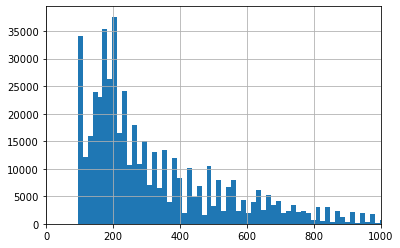

In [64]:
df_len[df_len.label == 'sn'].length.hist(bins = 400)
plt.xlim((0,1_000))
#plt.xlim((1_000,6_000))

(0.0, 1000.0)

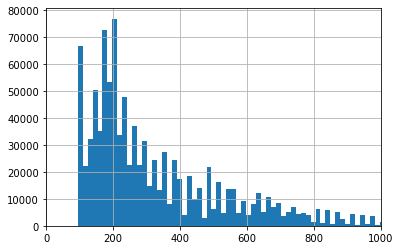

In [65]:
df_len[df_len.label == 'p'].length.hist(bins = 400)
plt.xlim((0,1_000))
#plt.xlim((1_000,6_000))

(0.0, 1000.0)

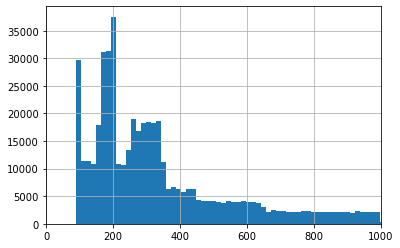

In [66]:
df_len[df_len.label == 'enhn'].length.hist(bins = 400)
plt.xlim((0,1_000))
#plt.xlim((1_000,6_000))

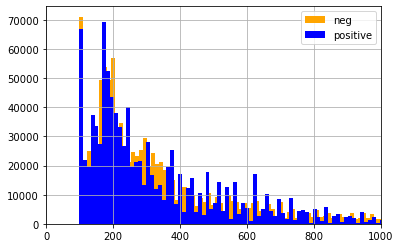

In [67]:
df_len[(df_len.label == 'sn')|(df_len.label == 'enhn')].length.hist(bins = 500, color = 'orange', label = 'neg')
df_len[df_len.label == 'p'].length.hist(bins = 500, color = 'blue', label = 'positive')
plt.legend()
plt.xlim((0,1_000))
plt.show()

In [68]:
q = 0.9
np.quantile(matrix_area_pos, q), np.quantile(matrix_area_neg, q)

(555.607775323564, 646.6072996799542)

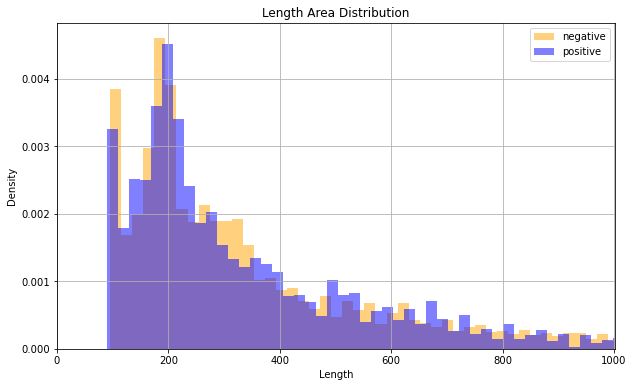

In [78]:
plt.figure(figsize=(10, 6))
pd.Series(df_len[(df_len.label == 'sn') | (df_len.label == 'enhn')].length).hist(
    bins=300, label='negative', color='orange', alpha=0.5, density=True
)  # Set transparency for neg
pd.Series(df_len[df_len.label == 'p'].length).hist(
    bins=300, label='positive', color='blue', alpha=0.5, density=True
)  # Set transparency for positive
plt.title('Length Area Distribution')
plt.xlabel('Length')  # Add x-axis label
plt.ylabel('Density')  # Add y-axis label
plt.legend()
plt.xlim((0, np.mean(matrix_area_pos) * 3))
plt.savefig(os.path.join(plots_dir, 'training_length_posneg_distribution.pdf'))
plt.show()

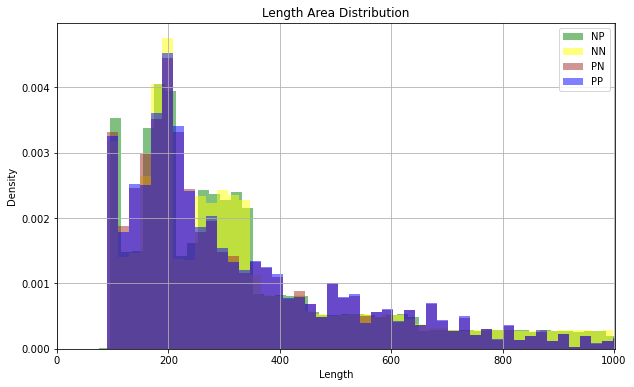

In [77]:
plt.figure(figsize=(10, 6))

pd.Series(df_spec_len[df_spec_len.label == 'hn'].length).hist(
    bins=300, label='NP', color='green', alpha=0.5, density=True
)  # Set transparency for positive
pd.Series(df_spec_len[df_spec_len.label == 'en'].length).hist(
    bins=300, label='NN', color='yellow', alpha=0.5, density=True
)  # Set transparency for positive
pd.Series(df_spec_len[(df_spec_len.label == 'sn')].length).hist(
    bins=300, label='PN', color='brown', alpha=0.5, density=True
)  # Set transparency for neg
pd.Series(df_spec_len[df_spec_len.label == 'p'].length).hist(
    bins=300, label='PP', color='blue', alpha=0.5, density=True
)  # Set transparency for positive

# sns.kdeplot(df_spec_len[df_spec_len.label == 'sn'].length, label='PN', color='brown', fill=False)
# sns.kdeplot(df_spec_len[df_spec_len.label == 'p'].length, label='PP', color='blue', fill=False)
# sns.kdeplot(df_spec_len[df_spec_len.label == 'hn'].length, label='NP', color='green', fill=False)
# sns.kdeplot(df_spec_len[df_spec_len.label == 'en'].length, label='NN', color='yellow', fill=False)


plt.title('Length Area Distribution')
plt.xlabel('Length')  # Add x-axis label
plt.ylabel('Density')  # Add y-axis label
plt.legend()
plt.xlim((0, np.mean(matrix_area_pos) * 3))
plt.savefig(os.path.join(plots_dir, 'training_length_posneg_eachclass_distribution.pdf'))
plt.show()

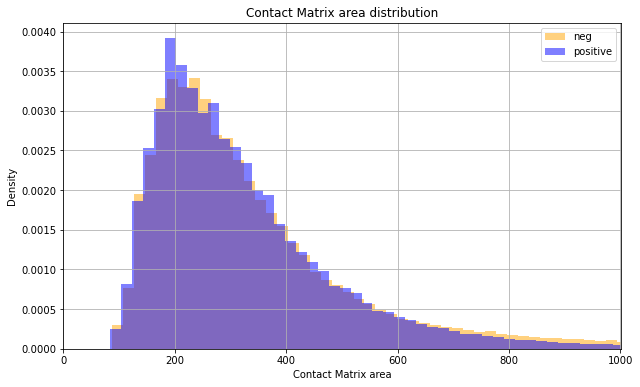

In [79]:
plt.figure(figsize = (10, 6))
pd.Series(matrix_area_neg).hist(bins=300, label='neg', color='orange', alpha=0.5, density = True)  # Set transparency for neg
pd.Series(matrix_area_pos).hist(bins=300, label='positive', color='blue', alpha=0.5, density = True)  # Set transparency for positive
plt.title(f'Contact Matrix area distribution')
plt.legend()
plt.xlabel('Contact Matrix area')  # Add x-axis label
plt.ylabel('Density')  # Add y-axis label
plt.xlim((0, np.mean(matrix_area_pos) * 3))
plt.savefig(os.path.join(plots_dir, 'training_contactmatrix_size_posneg_distribution.pdf'))
plt.show()

In [45]:
# plot_sample(sample, plot_interaction_negatives=True)

In [14]:
(df_len.label == 'p').value_counts()

False    862954
True     861962
Name: label, dtype: int64

In [15]:
df_len[df_len.length == 5970].label.value_counts()

p       2980
sn      1532
enhn    1477
Name: label, dtype: int64

In [16]:
df_len[df_len.length == 100].label.value_counts()

p       46694
sn      23891
enhn    21704
Name: label, dtype: int64

In [17]:
df_len[df_len.length == 200].label.value_counts()

p       30178
enhn    17290
sn      15044
Name: label, dtype: int64

In [18]:
small_l = df_len.length.quantile(0.1)
print(df_len[df_len['length'] < small_l].label.value_counts())
print('\n')
big_l = df_len.length.quantile(0.7)
print(df_len[df_len['length'] > big_l].label.value_counts())

p       85744
sn      44031
enhn    39795
Name: label, dtype: int64


p       253233
enhn    135453
sn      126514
Name: label, dtype: int64


In [19]:
(float(df_len.sort_values('length').quantile(0.2))/6)/80

0.35416666666666663

In [20]:
(float(df_len.sort_values('length').quantile(0.5))/6)/80

0.5625

In [21]:
#balance set
assert abs(df_len.label.value_counts().p/df_len.shape[0] - 0.5) < 0.05

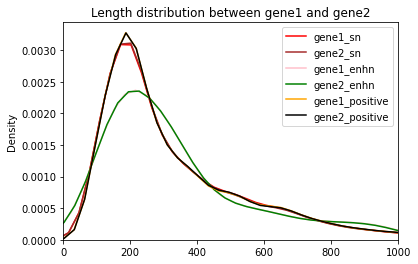

In [22]:
sns.kdeplot(sn_len_1, color = 'red', label = 'gene1_sn')
sns.kdeplot(sn_len_2, color = 'brown', label = 'gene2_sn')
sns.kdeplot(enhn_len_1, color = 'pink', label = 'gene1_enhn')
sns.kdeplot(enhn_len_2, color = 'green', label = 'gene2_enhn')
sns.kdeplot(pos_len_1, color = 'orange', label = 'gene1_positive')
sns.kdeplot(pos_len_2, color = 'black', label = 'gene2_positive')
plt.title(f'Length distribution between gene1 and gene2')
plt.legend()
plt.xlim((0,1_000))
plt.show()

### Dataloader 

In [21]:
dataset_train, policies_train = obtain_train_dataset_paris(DIMENSION, TRAIN_HQ, FINETUNING, per_sample_p, proportion_sn, proportion_hn, proportion_en, min_n_groups_train, max_n_groups_train, SPECIE, scaling_factor = 5)
sampler_train = torch.utils.data.RandomSampler(dataset_train)
batch_sampler_train = torch.utils.data.BatchSampler(sampler_train, 32, drop_last=False)
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                               collate_fn=utils.collate_fn_nt2, num_workers=2)

In [ ]:
n_total = 40
shapes_rna1 = []
shapes_rna2 = []
for _, (samples, labels) in tqdm(enumerate(data_loader_train), total = n_total):
    rna1, rna2 = samples
    shapes_rna1.append(rna1.shape[-1])
    shapes_rna2.append(rna2.shape[-1])
    if _ == n_total:
        break

In [23]:
np.min(shapes_rna1)

16

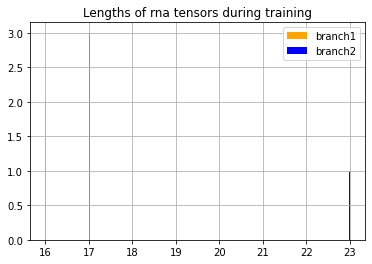

In [24]:
pd.Series(shapes_rna1).hist(bins = 300, color = 'orange', label = 'branch1')
pd.Series(shapes_rna2).hist(bins = 300, color = 'blue', label = 'branch2')
plt.legend()
#plt.xlim((0,100))
plt.title('Lengths of rna tensors during training')
plt.show()

# Validation set 

In [21]:
dataset_val, policies_val = obtain_val_dataset_paris(DIMENSION, FINETUNING, min_n_groups_val, max_n_groups_val, SPECIE, scaling_factor = 5)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/17734 [00:00<?, ?it/s]

median: 200.0


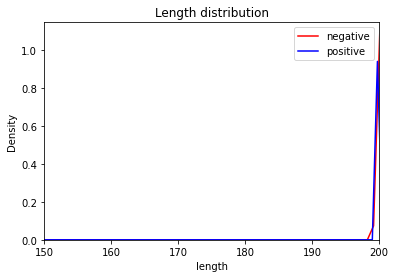

In [22]:
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(1)):
    for sample in tqdm(dataset_val, total=len(dataset_val)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
        
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

print('median:', df_len.length.median())

sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.xlim((150, 200))
plt.legend()

# Esecuzione data loader external dataset

In [23]:
dataset_train, policies_train = obtain_train_dataset('splash', DIMENSION, TRAIN_HQ, FINETUNING, per_sample_p, proportion_sn, proportion_hn, proportion_en, min_n_groups_train, max_n_groups_train, SPECIE, scaling_factor = 5)

In [24]:
dataset_train

In [33]:
n_epochs = 50
sn_len_1 = []
sn_len_2 = []
enhn_len_1 = []
enhn_len_2 = []
pos_len_1 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

all_couples_id = []

for epoch in tqdm(range(n_epochs)):
    dataset_train, policies_train = obtain_train_dataset('splash', DIMENSION, np.nan, np.nan, per_sample_p, proportion_sn, proportion_hn, proportion_en, min_n_groups_train, max_n_groups_train, SPECIE, scaling_factor = 5)
    for sample in dataset_train:
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append(np.sqrt((box.x2-box.x1)*(box.y2-box.y1)))
        else:
            if sample.policy == 'smartneg':
                sn_len_1.append(box.x2-box.x1)
                sn_len_2.append(box.y2-box.y1)
            else:
                enhn_len_1.append(box.x2-box.x1)
                enhn_len_2.append(box.y2-box.y1)
            matrix_area_neg.append(np.sqrt((box.x2-box.x1)*(box.y2-box.y1)))

        g1 = re.search('(.*)_(.*)_(.*)', sample.gene1).group(1)
        g2 = re.search('(.*)_(.*)_(.*)', sample.gene2).group(1)
        all_couples_id.append(g1 + '_' + g2)
        all_couples_id.append(g2 + '_' + g1)

pos_len = pos_len_1+pos_len_2
label_p = ['p' for i in range(len(pos_len))]
sn_len = sn_len_1+sn_len_2
label_sn = ['sn' for i in range(len(sn_len))]
enhn_len = enhn_len_1+enhn_len_2
label_enhn = ['enhn' for i in range(len(enhn_len))]
label = label_p + label_sn + label_enhn
length = pos_len + sn_len + enhn_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/50 [00:00<?, ?it/s]

In [29]:
df_len.label.value_counts()

p       26766
sn      13556
enhn    13366
Name: label, dtype: int64

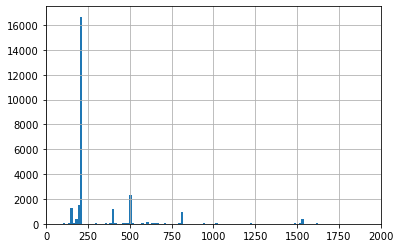

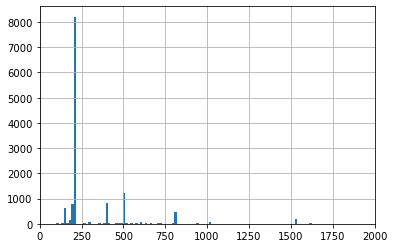

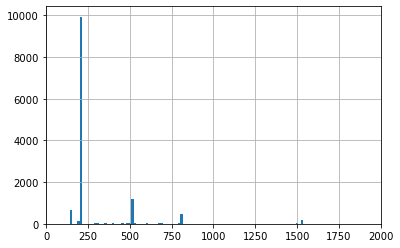

In [30]:
print_df_len(df_len, xlim = 2_000)

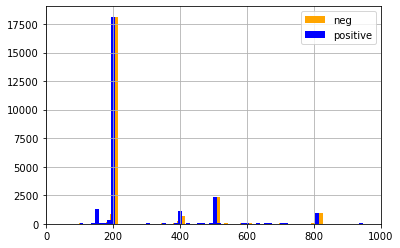

In [31]:
df_len[(df_len.label == 'sn')|(df_len.label == 'enhn')].length.hist(bins = 500, color = 'orange', label = 'neg')
df_len[df_len.label == 'p'].length.hist(bins = 500, color = 'blue', label = 'positive')
plt.legend()
plt.xlim((0,1_000))
plt.show()

# Combined dataset

In [ ]:
n_epochs = 1
batch_size = 64

for epoch in tqdm(range(n_epochs)):

    dataset_train, policies_train = obtain_train_dataset('psoralen', DIMENSION, TRAIN_HQ, FINETUNING, per_sample_p, proportion_sn, proportion_hn, proportion_en, min_n_groups_train, max_n_groups_train, SPECIE, scaling_factor = 5)
    custom_data_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=utils.collate_fn_nt3)

    neg_len_1 = []
    pos_len_1 = []
    neg_len_2 = []
    pos_len_2 = []
    matrix_area_neg = []
    matrix_area_pos = []

    for s, targets in tqdm(custom_data_loader, total = len(custom_data_loader)): #tqdm(custom_data_loader, total = len(custom_data_loader)):
        for sample in targets:
            box = sample['bbox']
            if sample['interacting']==1:
                pos_len_1.append(box.x2-box.x1)
                pos_len_2.append(box.y2-box.y1)
                matrix_area_pos.append(np.sqrt((box.x2-box.x1)*(box.y2-box.y1)))
            else:
                neg_len_1.append(box.x2-box.x1)
                neg_len_2.append(box.y2-box.y1)
                matrix_area_neg.append(np.sqrt((box.x2-box.x1)*(box.y2-box.y1)))

In [35]:
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

In [36]:
len(neg_len)/2

1416.0

In [37]:
len(pos_len)/2

1528.0

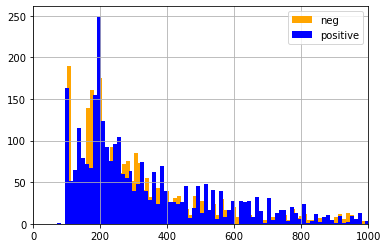

In [38]:
df_len[(df_len.label == 'sn')|(df_len.label == 'n')].length.hist(bins = 500, color = 'orange', label = 'neg')
df_len[df_len.label == 'p'].length.hist(bins = 500, color = 'blue', label = 'positive')
plt.legend()
plt.xlim((0,1_000))
plt.show()

In [39]:
q = 0.9
np.quantile(matrix_area_pos, q), np.quantile(matrix_area_neg, q)

(565.1052664183272, 661.2600368651467)

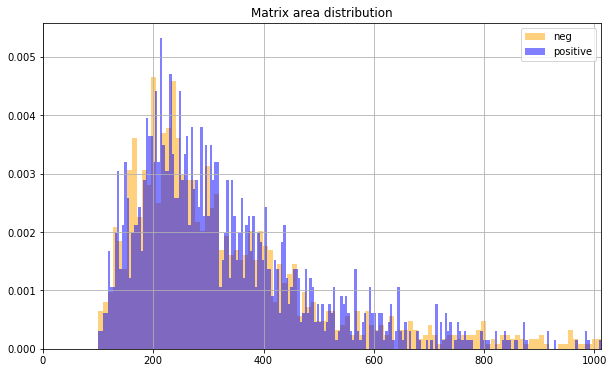

In [40]:
plt.figure(figsize = (10, 6))
pd.Series(matrix_area_neg).hist(bins=500, label='neg', color='orange', alpha=0.5, density = True)  # Set transparency for neg
pd.Series(matrix_area_pos).hist(bins=500, label='positive', color='blue', alpha=0.5, density = True)  # Set transparency for positive
plt.title(f'Matrix area distribution')
plt.legend()
plt.xlim((0, np.mean(matrix_area_pos) * 3))
plt.show()